# Dataset Generator

The purpose of this notebook is to generate the pairs to be used as dataset for the pairwise boosting algorithm.

## Libraries

In [1]:
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd

Importing configuration file

In [2]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

In [3]:
%cd ..

from scripts import plotHelper

%cd pairwise_boosting/

/Users/bacci/GitHub/COMPACT/notebooks
/Users/bacci/GitHub/COMPACT/notebooks/pairwise_boosting


## Import Data

Importing every `CSV` file in the `binary` folder, merge them and create the labelled dataframe.

In [4]:
# Base directory containing the folders
base_dir = config["DEFAULT"]["binary_path"]

# Initialize an empty dictionary to store DataFrames
dataframes = {}

# Traverse the directory structure
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".csv"):
            # Construct the full file path
            file_path = os.path.join(root, file)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path, dtype=str)

            # Store the DataFrame in the dictionary with a unique key (e.g., file name)
            dataframes[file] = df

In [5]:
bin_df = pd.concat(dataframes.values(), ignore_index=True)

Set every column's type to string in order to avoid conversions and misrepresentation of the binary data.

In [6]:
bin_df = bin_df.astype(str)

Drop all the Element ID columns, since by definition they are always the same.

In [7]:
# Columns to drop
drop_starts_with = ["e_id_"]
bin_df = bin_df.drop(
    columns=[col for col in bin_df.columns if col.startswith(tuple(drop_starts_with))]
)

In [8]:
bin_df = bin_df.replace("nan", "0")

In [9]:
def zero_pad_column(df, exclude=[]):
    max_lengths = df.drop(columns=exclude).applymap(lambda x: len(str(x))).max()
    for col in df.columns:
        if col not in exclude:
            max_length = max_lengths[col]
            df[col] = df[col].fillna("").astype(str).str.ljust(max_length, "0")
    return df

In [10]:
df = zero_pad_column(bin_df, ["mac", "label"])

/var/folders/kz/mqbx964j4w53vxgzd7rlzx380000gn/T/ipykernel_7685/3590092166.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_lengths = df.drop(columns=exclude).applymap(lambda x: len(str(x))).max()


In [11]:
df = df.drop(columns=["frame_check_seq", "len_dsss", "ssid"])

Remove noise within Pintor22 Dataset

In [12]:
df = df[df["mac"] != "00:0f:00:6a:68:8b"]

In [13]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,dsss_parameter,len_ht_cap,ht_cap,len_vht_cap,vht_cap,len_ext_cap,ext_cap,len_vst,vst,len_ext_tags,ext_tags,label
0,d2:6b:aa:b5:fb:ed,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,0010110100000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001011,0000000000000000000010000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12Pro_C
1,d2:6b:aa:b5:fb:ed,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,0010110100000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001011,0000000000000000000010000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12Pro_C
2,d2:6b:aa:b5:fb:ed,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000110,00011010,0010110100000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001011,0000000000000000000010000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12Pro_C
3,d2:6b:aa:b5:fb:ed,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000110,00011010,0010110100000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001011,0000000000000000000010000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12Pro_C
4,d2:6b:aa:b5:fb:ed,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00001011,00011010,0010110100000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001011,0000000000000000000010000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12Pro_C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76699,ec:9b:f3:75:8e:40,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00001001,00011010,0110001100010001000101111111111111111111000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010001000000000000001010000...,00001001,0101000001101111100110100001000000010000110111...,00000000,0000000000000000000000000000000000000000000000...,SamsungS6_H
76700,ec:9b:f3:75:8e:40,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00001010,00011010,0110001100010001000101111111111111111111000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010001000000000000001010000...,00001001,0101000001101111100110100001000000010000110111...,00000000,0000000000000000000000000000000000000000000000...,SamsungS6_H
76701,ec:9b:f3:75:8e:40,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00001010,00011010,0110001100010001000101111111111111111111000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010001000000000000001010000...,00001001,0101000001101111100110100001000000010000110111...,00000000,0000000000000000000000000000000000000000000000...,SamsungS6_H
76702,ec:

In [14]:
def concat_values(series):
    return "".join(series)

In [15]:
# Columns to group by
groupby_column = "mac"

# Column to concatenate
concatenate_column = "dsss_parameter"

In [16]:
agg_dict = {
    col: "first"
    for col in df.columns
    if col != groupby_column and col != concatenate_column
}
agg_dict[concatenate_column] = concat_values

In [17]:
df = df.groupby(groupby_column).agg(agg_dict).reset_index()

In [18]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_vht_cap,vht_cap,len_ext_cap,ext_cap,len_vst,vst,len_ext_tags,ext_tags,label,dsss_parameter
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,0000000000000000000000000000000000000000000000...,00000110,0000000000001000000011111000010000000001010000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,HuaweiP20_G,0000000100000001000000100000001000000010000000...
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001001,0000000100000000000010000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,SamsungM31_A,0000000100000001000000100000001100000011000001...
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone11_C,0000101100001011
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone11_B,0000101000001010
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12_W,0000001100000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,fe:f9:ac:47:0d:b7,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12_W,0000101100001011
4790,fe:f9:fc:fb:83:9e,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000101000000000101111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000010000000000000010001000010000000000000000...,00001001,0000000000010111111100100000101000000000000000...,00000000,0000000000000000000000000000000000000000000000...,iPhone6_N,0000011000000110000001110000011100001000000010...
4791,fe:fc:07:34:10:69,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,00

In [19]:
# Determine the mean length of the strings in the column
mean_length = df["dsss_parameter"].str.len().mean()

# Round the mean length up to the next integer
rounded_length = int(np.ceil(mean_length))

# Cut any strings that exceed the rounded length
df["dsss_parameter"] = df["dsss_parameter"].str[:rounded_length]

# Zero-pad the strings to the rounded length
df["dsss_parameter"] = df["dsss_parameter"].str.zfill(rounded_length)

In [20]:
# Specify the label column
label_column = "label"

# Create a list of columns with the label column at the end
cols = [col for col in df.columns if col != label_column] + [label_column]

# Reorder the DataFrame columns
df = df[cols]

In [21]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_vht_cap,vht_cap,len_ext_cap,ext_cap,len_vst,vst,len_ext_tags,ext_tags,dsss_parameter,label
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,0000000000000000000000000000000000000000000000...,00000110,0000000000001000000011111000010000000001010000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001000000010000000...,HuaweiP20_G
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001001,0000000100000000000010000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001100000011000001...,SamsungM31_A
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_C
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_B
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,fe:f9:ac:47:0d:b7,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
4790,fe:f9:fc:fb:83:9e,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000101000000000101111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000010000000000000010001000010000000000000000...,00001001,0000000000010111111100100000101000000000000000...,00000000,0000000000000000000000000000000000000000000000...,0000011000000110000001110000011100001000000010...,iPhone6_N
4791,fe:fc:07:34:10:69,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000.

In [22]:
df["label"].unique()

array(['HuaweiP20_G', 'SamsungM31_A', 'iPhone11_C', 'iPhone11_B',
       'iPhone12_W', 'SamsungS7_I', 'iPhone6_N', 'iPhone11_M',
       'iPhone12_M', 'iPhone7_X', 'iPhoneXR_L', 'GooglePixel3A_V',
       'iPhoneXSMax_M', 'GooglePixel3A_L', 'XiaomiRedmiNote9S_T',
       'OnePlusNord_O', 'SamsungJ6_K', 'XiaomiA2_E', 'iPhoneXR_A',
       'S21Ultra_M', 'iPhone11_F', 'iPhoneXR_U', 'iPhone7_F',
       'OppoFindX3Neo_A', 'SamsungS4_C', 'HuaweiHonor9_R',
       'XiaomiRedmiNote7_S', 'HuaweiP10_Q', 'HuaweiL21_D',
       'iPhone12Pro_C', 'XiaomiRedmi5_J', 'XiaomiRedmi4_B', 'SamsungS6_H'],
      dtype=object)

## Drop Duplicates

In [23]:
columns_to_consider = [col for col in df.columns if col not in ["mac", "label"]]

In [24]:
columns_to_consider

['len_ssid',
 'len_sup_rates',
 'supported_rates',
 'len_ext_sup_rates',
 'ext_sup_rates',
 'len_ht_cap',
 'ht_cap',
 'len_vht_cap',
 'vht_cap',
 'len_ext_cap',
 'ext_cap',
 'len_vst',
 'vst',
 'len_ext_tags',
 'ext_tags',
 'dsss_parameter']

In [25]:
df = df.drop_duplicates(subset=columns_to_consider)

In [26]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_vht_cap,vht_cap,len_ext_cap,ext_cap,len_vst,vst,len_ext_tags,ext_tags,dsss_parameter,label
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,0000000000000000000000000000000000000000000000...,00000110,0000000000001000000011111000010000000001010000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001000000010000000...,HuaweiP20_G
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001001,0000000100000000000010000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001100000011000001...,SamsungM31_A
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_C
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_B
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756,fe:5b:80:1e:44:c4,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111111000000...,00001100,1001001011111001100100010011001111111010111111...,00001010,0000000000000000000010101000001000000000010000...,00001000,0000000001010000111100100000100000000000001001...,00000011,0000001000000000000111110000000000000000000000...,0000000000000000000000010000000100000010000000...,XiaomiRedmiNote9S_T
4757,fe:5d:a5:9d:8d:f7,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0110111000000001000000111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000000...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000010000000100000010000000...,XiaomiA2_E
4768,fe:93:35:c4:ec:bb,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111

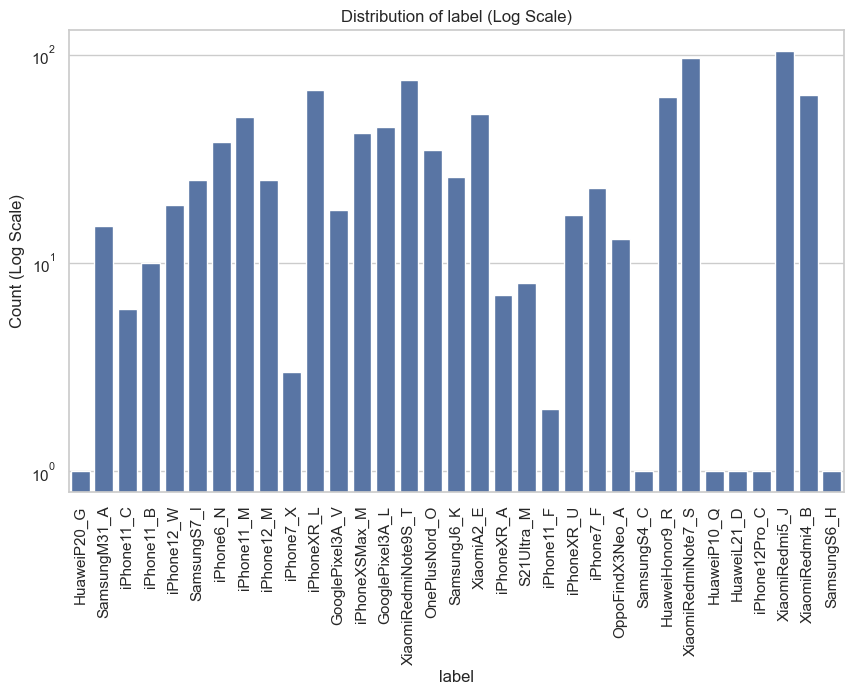

In [27]:
plotHelper.plot_label_distribution(df, "label", log_scale=True)

In [28]:
# df = df.groupby('label').apply(lambda x: x.sample(n=min(10, len(x)))).reset_index(drop=True)

In [29]:
df["label"].unique()

array(['HuaweiP20_G', 'SamsungM31_A', 'iPhone11_C', 'iPhone11_B',
       'iPhone12_W', 'SamsungS7_I', 'iPhone6_N', 'iPhone11_M',
       'iPhone12_M', 'iPhone7_X', 'iPhoneXR_L', 'GooglePixel3A_V',
       'iPhoneXSMax_M', 'GooglePixel3A_L', 'XiaomiRedmiNote9S_T',
       'OnePlusNord_O', 'SamsungJ6_K', 'XiaomiA2_E', 'iPhoneXR_A',
       'S21Ultra_M', 'iPhone11_F', 'iPhoneXR_U', 'iPhone7_F',
       'OppoFindX3Neo_A', 'SamsungS4_C', 'HuaweiHonor9_R',
       'XiaomiRedmiNote7_S', 'HuaweiP10_Q', 'HuaweiL21_D',
       'iPhone12Pro_C', 'XiaomiRedmi5_J', 'XiaomiRedmi4_B', 'SamsungS6_H'],
      dtype=object)

In [30]:
df["label"].nunique()

33

In [31]:
df.reset_index(drop=True, inplace=True)

In [32]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_vht_cap,vht_cap,len_ext_cap,ext_cap,len_vst,vst,len_ext_tags,ext_tags,dsss_parameter,label
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,0000000000000000000000000000000000000000000000...,00000110,0000000000001000000011111000010000000001010000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001000000010000000...,HuaweiP20_G
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001001,0000000100000000000010000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001100000011000001...,SamsungM31_A
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_C
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_B
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00001000,0000000000000000000010000000010000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,fe:5b:80:1e:44:c4,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111111000000...,00001100,1001001011111001100100010011001111111010111111...,00001010,0000000000000000000010101000001000000000010000...,00001000,0000000001010000111100100000100000000000001001...,00000011,0000001000000000000111110000000000000000000000...,0000000000000000000000010000000100000010000000...,XiaomiRedmiNote9S_T
952,fe:5d:a5:9d:8d:f7,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0110111000000001000000111111111100000000000000...,00000000,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000000...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000010000000100000010000000...,XiaomiA2_E
953,fe:93:35:c4:ec:bb,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111111

In [33]:
df.to_csv("../../data/interim/pairwise_boosting.csv", index=False)

In [34]:
for col in df.columns:
    string_length = len(df[col].iloc[0]) if not df[col].empty else 0
    print(f"Column '{col}' has strings of length {string_length}")

Column 'mac' has strings of length 17
Column 'len_ssid' has strings of length 8
Column 'len_sup_rates' has strings of length 8
Column 'supported_rates' has strings of length 64
Column 'len_ext_sup_rates' has strings of length 8
Column 'ext_sup_rates' has strings of length 64
Column 'len_ht_cap' has strings of length 8
Column 'ht_cap' has strings of length 208
Column 'len_vht_cap' has strings of length 8
Column 'vht_cap' has strings of length 96
Column 'len_ext_cap' has strings of length 8
Column 'ext_cap' has strings of length 88
Column 'len_vst' has strings of length 8
Column 'vst' has strings of length 1336
Column 'len_ext_tags' has strings of length 8
Column 'ext_tags' has strings of length 240
Column 'dsss_parameter' has strings of length 128
Column 'label' has strings of length 11


Dropping columns I know from previous works are not impacting the accuracy (wasted training time).

In [35]:
df = df.drop(
    columns=[
        "len_ssid",
        "len_sup_rates",
        "supported_rates",
        "len_ext_sup_rates",
        "ext_sup_rates",
        "len_vht_cap",
        "vht_cap",
        "len_ext_tags",
        "ext_tags",
    ]
)

In [36]:
df.columns

Index(['mac', 'len_ht_cap', 'ht_cap', 'len_ext_cap', 'ext_cap', 'len_vst',
       'vst', 'dsss_parameter', 'label'],
      dtype='object')

## Generate `string_df`

`string_df` is now free of duplicates, i.e. probe burst with an identical configuration, and different `mac`

In [37]:
df["concatenated"] = (
    df.drop(columns=["label", "mac"]).astype(str).apply(lambda x: "".join(x), axis=1)
)

# If you want to keep the 'label' column in the final dataframe:
df_result = df[["label", "concatenated"]]

df_result = df_result.sort_values("label")

# Step 3: Save to CSV
output_file_path = (
    "../../data/interim/string_df.csv"  # replace with your desired output file path
)
df_result.to_csv(output_file_path, index=False)

## Generate `pairs_df`

In [38]:
# Create all possible combinations of indexes (pairs)
index_pairs = list(combinations(df.index, 2))

# Separate matching and non-matching pairs
matching_pairs = []
non_matching_pairs = []

for pair in index_pairs:
    index1, index2 = pair
    label1 = df.loc[index1, "label"]
    label2 = df.loc[index2, "label"]

    if label1 == label2:
        matching_pairs.append((index1, index2, 1, label1, label2))
    else:
        non_matching_pairs.append((index1, index2, -1, label1, label2))

In [39]:
len(matching_pairs)

26647

In [40]:
len(non_matching_pairs)

429843

In [41]:
type(non_matching_pairs)

list

In [42]:
non_matching_pairs

[(0, 1, -1, 'HuaweiP20_G', 'SamsungM31_A'),
 (0, 2, -1, 'HuaweiP20_G', 'iPhone11_C'),
 (0, 3, -1, 'HuaweiP20_G', 'iPhone11_B'),
 (0, 4, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 5, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 6, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 7, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 8, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 9, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 10, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 11, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 12, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 13, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 14, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 15, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 16, -1, 'HuaweiP20_G', 'iPhone11_C'),
 (0, 17, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 18, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 19, -1, 'HuaweiP20_G', 'iPhone6_N'),
 (0, 20, -1, 'HuaweiP20_G', 'iPhone11_M'),
 (0, 21, -1, 'HuaweiP20_G', 'iPhone12_M'),
 (0, 22, -1, 'HuaweiP20_G', 'iPhone11_B'),
 (0, 23, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 24,

In [43]:
from collections import Counter, defaultdict
import random

In [44]:
# Step 1: Count the occurrences of each device
device_counts = Counter()
for record in non_matching_pairs:
    device_counts[record[3]] += 1
    device_counts[record[4]] += 1

# Step 2: Calculate the target number of appearances for each device
total_devices = sum(device_counts.values())
unique_devices = len(device_counts)
target_count_per_device = (10000 * 2) // unique_devices  # Each record has two devices

# Step 3: Create a dictionary to store selected records
selected_records = defaultdict(list)

# Step 4: Select records while ensuring uniform distribution
random.shuffle(non_matching_pairs)
for record in non_matching_pairs:
    d1, d2 = record[3], record[4]
    if (
        len(selected_records[d1]) < target_count_per_device
        and len(selected_records[d2]) < target_count_per_device
    ):
        selected_records[d1].append(record)
        selected_records[d2].append(record)

# Step 5: Flatten the selected records and trim to the desired length
final_records = []
for records in selected_records.values():
    final_records.extend(records)

# Ensure we only get 10,000 records
final_records = final_records[:2500]

# Output the final downsampled list
print(final_records)
print(f"Total records selected: {len(final_records)}")

[(343, 454, -1, 'iPhone6_N', 'GooglePixel3A_L'), (167, 297, -1, 'iPhone6_N', 'iPhone11_M'), (332, 403, -1, 'iPhone6_N', 'iPhoneXR_U'), (254, 434, -1, 'iPhone6_N', 'XiaomiA2_E'), (550, 823, -1, 'iPhone6_N', 'XiaomiRedmi5_J'), (292, 697, -1, 'iPhone6_N', 'XiaomiRedmi4_B'), (447, 930, -1, 'OnePlusNord_O', 'iPhone6_N'), (550, 615, -1, 'iPhone6_N', 'HuaweiHonor9_R'), (214, 687, -1, 'iPhone6_N', 'XiaomiRedmi5_J'), (474, 525, -1, 'iPhone6_N', 'iPhone7_F'), (192, 401, -1, 'XiaomiRedmiNote9S_T', 'iPhone6_N'), (171, 478, -1, 'iPhone6_N', 'iPhoneXR_L'), (931, 942, -1, 'iPhone6_N', 'OppoFindX3Neo_A'), (171, 817, -1, 'iPhone6_N', 'HuaweiHonor9_R'), (200, 401, -1, 'iPhoneXR_U', 'iPhone6_N'), (199, 428, -1, 'iPhone11_C', 'iPhone6_N'), (332, 588, -1, 'iPhone6_N', 'XiaomiRedmi4_B'), (78, 930, -1, 'iPhone12_W', 'iPhone6_N'), (362, 853, -1, 'iPhone6_N', 'XiaomiRedmiNote7_S'), (444, 756, -1, 'iPhone6_N', 'XiaomiRedmiNote7_S'), (428, 514, -1, 'iPhone6_N', 'OnePlusNord_O'), (164, 428, -1, 'XiaomiRedmiNote9S

In [45]:
final_records

[(343, 454, -1, 'iPhone6_N', 'GooglePixel3A_L'),
 (167, 297, -1, 'iPhone6_N', 'iPhone11_M'),
 (332, 403, -1, 'iPhone6_N', 'iPhoneXR_U'),
 (254, 434, -1, 'iPhone6_N', 'XiaomiA2_E'),
 (550, 823, -1, 'iPhone6_N', 'XiaomiRedmi5_J'),
 (292, 697, -1, 'iPhone6_N', 'XiaomiRedmi4_B'),
 (447, 930, -1, 'OnePlusNord_O', 'iPhone6_N'),
 (550, 615, -1, 'iPhone6_N', 'HuaweiHonor9_R'),
 (214, 687, -1, 'iPhone6_N', 'XiaomiRedmi5_J'),
 (474, 525, -1, 'iPhone6_N', 'iPhone7_F'),
 (192, 401, -1, 'XiaomiRedmiNote9S_T', 'iPhone6_N'),
 (171, 478, -1, 'iPhone6_N', 'iPhoneXR_L'),
 (931, 942, -1, 'iPhone6_N', 'OppoFindX3Neo_A'),
 (171, 817, -1, 'iPhone6_N', 'HuaweiHonor9_R'),
 (200, 401, -1, 'iPhoneXR_U', 'iPhone6_N'),
 (199, 428, -1, 'iPhone11_C', 'iPhone6_N'),
 (332, 588, -1, 'iPhone6_N', 'XiaomiRedmi4_B'),
 (78, 930, -1, 'iPhone12_W', 'iPhone6_N'),
 (362, 853, -1, 'iPhone6_N', 'XiaomiRedmiNote7_S'),
 (444, 756, -1, 'iPhone6_N', 'XiaomiRedmiNote7_S'),
 (428, 514, -1, 'iPhone6_N', 'OnePlusNord_O'),
 (164, 428, -

In [46]:
non_matching_pairs = final_records

In [47]:
matching_pairs

[(1, 96, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 110, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 112, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 132, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 267, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 280, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 287, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 303, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 409, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 432, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 459, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 513, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 907, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 946, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (2, 16, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 25, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 51, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 69, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 199, 1, 'iPhone11_C', 'iPhone11_C'),
 (3, 22, 1, 'iPhone11_B', 'iPhone11_B'),
 (3, 29, 1, 'iPhone11_B', 'iPhone11_B'),
 (3, 40, 1, 'iPhone11_B', 'iPhone11_B'),
 (3, 82, 1, 'iPhone11_B', 'i

In [48]:
# Step 1: Count the occurrences of each device
device_counts = Counter()
for record in matching_pairs:
    device_counts[record[3]] += 1
    device_counts[record[4]] += 1

# Step 2: Calculate the target number of appearances for each device
total_devices = sum(device_counts.values())
unique_devices = len(device_counts)
target_count_per_device = (10000 * 2) // unique_devices  # Each record has two devices

# Step 3: Create a dictionary to store selected records
selected_records = defaultdict(list)

# Step 4: Select records while ensuring uniform distribution
random.shuffle(matching_pairs)
for record in matching_pairs:
    d1, d2 = record[3], record[4]
    if (
        len(selected_records[d1]) < target_count_per_device
        and len(selected_records[d2]) < target_count_per_device
    ):
        selected_records[d1].append(record)
        selected_records[d2].append(record)

# Step 5: Flatten the selected records and trim to the desired length
final_records = []
for records in selected_records.values():
    final_records.extend(records)

# Ensure we only get 10,000 records
matching_pairs = final_records[:2500]

In [49]:
# Convert lists to dataframes
columns = ["Item 1", "Item 2", "Equality", "device1", "device2"]
matching_df = pd.DataFrame(matching_pairs, columns=columns)
non_matching_df = pd.DataFrame(non_matching_pairs, columns=columns)

# Combine dataframes
df = pd.concat([matching_df, non_matching_df])

In [50]:
df

,Item 1,Item 2,Equality,device1,device2
0,67,68,1,iPhone12_W,iPhone12_W
1,67,68,1,iPhone12_W,iPhone12_W
2,17,78,1,iPhone12_W,iPhone12_W
3,17,78,1,iPhone12_W,iPhone12_W
4,58,67,1,iPhone12_W,iPhone12_W
...,...,...,...,...,...
2495,296,860,-1,SamsungJ6_K,XiaomiRedmi5_J
2496,464,901,-1,SamsungJ6_K,iPhone7_F
2497,485,884,-1,SamsungJ6_K,XiaomiRedmiNote9S_T
2498,237,610,-1,SamsungJ6_K,XiaomiRedmiNote7_S


In [51]:
import matplotlib.pyplot as plt

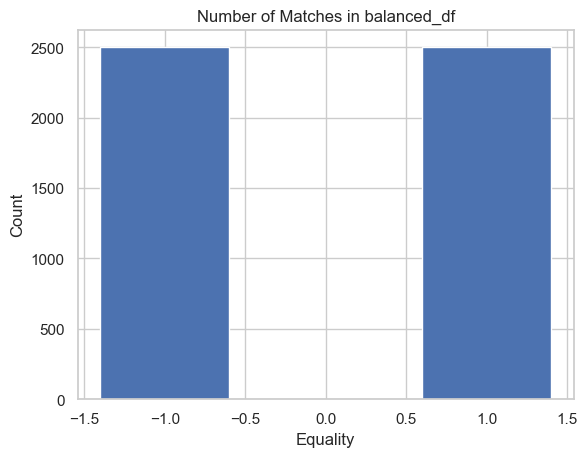

In [52]:
# Count the number of matches in balanced_df
match_counts = df["Equality"].value_counts()

# Create the bar plot
plt.bar(match_counts.index, match_counts.values)

# Set the labels and title
plt.xlabel("Equality")
plt.ylabel("Count")
plt.title("Number of Matches in balanced_df")

# Show the plot
plt.show()

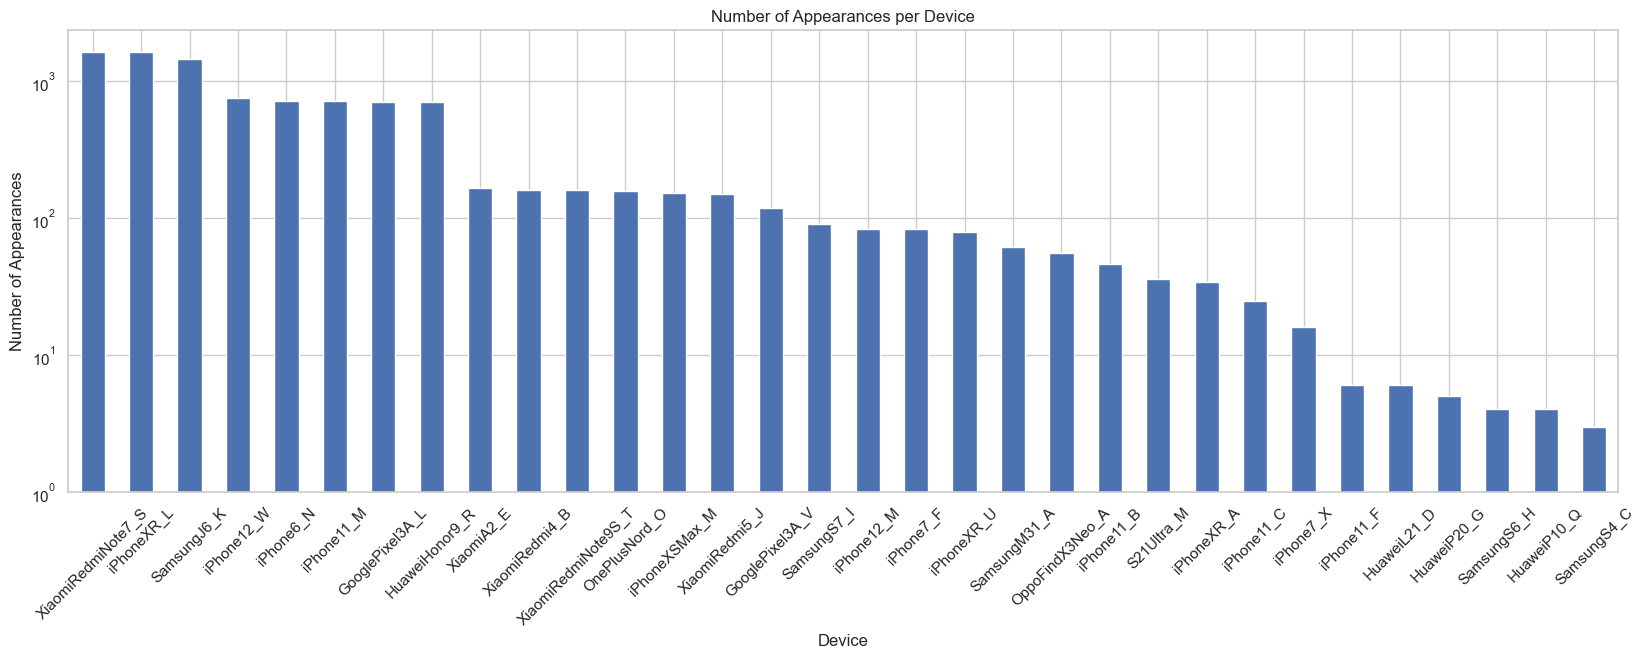

In [53]:
# Count occurrences in device1 and device2
device1_counts = df["device1"].value_counts()
device2_counts = df["device2"].value_counts()

# Combine the counts
combined_counts = device1_counts.add(device2_counts, fill_value=0)

# Plot the combined counts using a bar plot
plt.figure(figsize=(20, 6))
combined_counts.sort_values(ascending=False).plot(kind="bar", log=True)
plt.title("Number of Appearances per Device")
plt.xlabel("Device")
plt.ylabel("Number of Appearances")
plt.xticks(rotation=45)
plt.show()

In [54]:
df

,Item 1,Item 2,Equality,device1,device2
0,67,68,1,iPhone12_W,iPhone12_W
1,67,68,1,iPhone12_W,iPhone12_W
2,17,78,1,iPhone12_W,iPhone12_W
3,17,78,1,iPhone12_W,iPhone12_W
4,58,67,1,iPhone12_W,iPhone12_W
...,...,...,...,...,...
2495,296,860,-1,SamsungJ6_K,XiaomiRedmi5_J
2496,464,901,-1,SamsungJ6_K,iPhone7_F
2497,485,884,-1,SamsungJ6_K,XiaomiRedmiNote9S_T
2498,237,610,-1,SamsungJ6_K,XiaomiRedmiNote7_S


In [55]:
df.to_csv("../../data/interim/balanced_pairs_df.csv", index=True)